# Submitted by:
 
* ID 1:315074310 
* ID 2:

# Warm up - KNN

Consider the [0,1] x [0,1] unit square. In this square we have points of several colors (classes). The goal is determine which color should be used to paint each of the non-painted points in the square using KNN.  

In [99]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generating the training set

In [100]:
# color palette
test_colors = ['dodgerblue', 'yellow', 'lightgreen']
train_colors = ['blue', 'orange', 'green']

def generate_data(N, cluster_type):
    """
    Generate 3 clusters of points each of size N. These clusters can be
    either separated, slightly mixed, or completely random.
    
    Args:
        N              - number of points in a single cluster
        cluster_type   - 'separated', 'mixed' or 'random'
        
    Return:
        X_train - numpy array of dim (3N,2) that holds (x,y) point coordinates 
        y_train - numpy array of dim (3N,) that holds labels (0,1, or 2)
    """
    np.random.seed(seed=50)
    
    if cluster_type == 'separated':
        x1 = 1 + 3*np.random.rand(N)
        y1 = 1 + 3*np.random.rand(N)

        x2 = 7 + 4*np.random.rand(N)
        y2 = 2 + 4*np.random.rand(N)

        x3 = 14 + 2*np.random.rand(N)
        y3 = 6  + 5*np.random.rand(N)
        
    elif cluster_type == 'mixed':
        x1 = 1 + 3*np.random.rand(N)
        y1 = 1 + 3*np.random.rand(N)

        x2 = 2 + 4*np.random.rand(N)
        y2 = 2 + 4*np.random.rand(N)

        x3 = 3 + 5*np.random.rand(N)
        y3 = 3 + 5*np.random.rand(N)
        
    elif cluster_type == 'random':
        x1 = np.random.rand(N)
        y1 = np.random.rand(N)

        x2 = np.random.rand(N)
        y2 = np.random.rand(N)

        x3 = np.random.rand(N)
        y3 = np.random.rand(N)
    else:
        return (None, None)
    
    # normalizing so that points are in the [0,1]x[0,1] box
    max_x = max(max(x1), max(x2), max(x3))
    x1 /= max_x
    x2 /= max_x
    x3 /= max_x
    max_y = max(max(y1), max(y2), max(y3))
    y1 /= max_y
    y2 /= max_y
    y3 /= max_y
        

    # preparing X_train by concatenating the three sets of points
    col1 = np.concatenate((x1, x2, x3))  # array of shape (3N,)
    col2 = np.concatenate((y1, y2, y3))  # array of shape (3N,)

    # reshaping into (N,2)
    col1 = col1.reshape(-1,1)                   # -1 means whichever value that make the reshape work
    col2 = col2.reshape(-1,1)

    X_train = np.column_stack((col1, col2))
    X_train = np.around(X_train,2)              # rounding to two decimals

    # preparing y_train by setting the proper labels 
    y_train = np.ones (3*N)
    y_train[0:N] -= 1 
    y_train[2*N:3*N] += 1

    return (X_train, y_train)

In [101]:
N= 70
# X_train, y_train = generate_data(N, 'separated')
# X_train, y_train = generate_data(N, 'random')
X_train, y_train = generate_data(N, 'mixed')

print ('X_train shape: ', X_train.shape)
print ('X_train first 10 points:')
print (X_train[0:10,])
print(X_train.shape)

print ('y_train shape: ', y_train.shape)
#print ('y_train first 10 points:')
#print (y_train[0:10,])

X_train shape:  (210, 2)
X_train first 10 points:
[[0.31 0.39]
 [0.21 0.5 ]
 [0.22 0.22]
 [0.28 0.41]
 [0.27 0.44]
 [0.5  0.49]
 [0.28 0.46]
 [0.42 0.29]
 [0.41 0.13]
 [0.24 0.14]]
(210, 2)
y_train shape:  (210,)


In [102]:
X_train[np.where(y_train == 2)][:,0]


array([0.82, 0.8 , 0.53, 0.75, 0.5 , 0.79, 0.79, 0.51, 0.39, 0.87, 0.39,
       0.78, 0.86, 0.79, 0.92, 0.78, 0.57, 0.64, 0.49, 0.89, 0.65, 0.63,
       0.74, 0.87, 0.98, 0.59, 0.53, 0.83, 0.92, 0.39, 0.54, 0.63, 0.52,
       0.67, 0.91, 0.77, 0.44, 0.64, 0.95, 0.54, 0.47, 0.53, 0.95, 0.59,
       0.48, 0.57, 0.74, 0.65, 0.77, 0.72, 0.82, 0.9 , 0.93, 0.55, 0.92,
       0.55, 0.55, 0.96, 0.67, 0.76, 0.58, 0.92, 1.  , 0.88, 0.6 , 0.5 ,
       0.89, 0.52, 0.84, 0.88])

In [103]:
X_train[np.where(y_train == 2)][:,1]

array([0.42, 0.54, 0.58, 0.49, 0.75, 0.62, 0.6 , 0.95, 0.59, 0.71, 0.43,
       0.42, 0.77, 0.53, 0.6 , 0.52, 0.59, 1.  , 0.93, 0.84, 0.77, 0.93,
       0.72, 0.95, 0.85, 0.5 , 0.86, 0.81, 0.68, 0.61, 0.82, 0.55, 0.61,
       0.64, 0.84, 0.72, 0.98, 0.98, 0.61, 0.77, 1.  , 0.77, 0.91, 0.48,
       0.73, 0.85, 0.84, 0.51, 0.43, 0.96, 0.56, 0.99, 0.6 , 0.55, 0.65,
       0.88, 0.47, 0.76, 0.95, 0.55, 0.43, 0.67, 0.59, 0.66, 0.55, 0.45,
       0.54, 0.61, 0.75, 0.87])

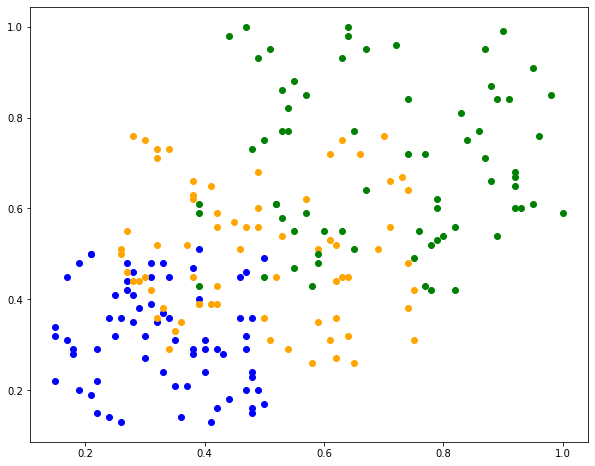

In [104]:
#plotting train poinats
for i in range(3):
    a_trn = X_train[np.where(y_train ==i)][:,0]  # grab X_train points for which label is i. grab x coordinate
    b_trn = X_train[np.where(y_train ==i)][:,1]  # grab X_train points for which label is i. grab y coordinate 
    plt.scatter(a_trn, b_trn, color=train_colors[i], label = i,)
    
plt.show()

In [111]:
resolution = 100
X_test = np.ones((resolution*resolution, 2))
for i in np.arange(0,resolution,):
    for j in np.arange(0,resolution):
        X_test[i*resolution + j,0] = i/resolution   
        X_test[i*resolution + j,1] = j/resolution
        
print ('Shape of X_test:', X_test.shape)
print ('Shape of Xtrain:', X_train.shape)

Shape of X_test: (10000, 2)
Shape of Xtrain: (210, 2)


### Use KNN to paint the whole unit square

1. Define a nearset neighbor classifier using KNeighborsClassifier and use it along with the training data to produce prediction for the given test points (X_test). 
2. Place your precdiction in the variable y_pred.
3. Plot below both train and test. See if result makes sense.

Repeat the above for the three modes of training data - 'separated', 'random', 'mixed'. 
1. For 'mixed' mode, try K=1 and K=9. Can you see a difference?
2. Use K=3, 'mixed' data with both L1 and L2 distances (i.e., Manhattan and Euclidean distances, respectively). Can you see a difference in the boundary shape?

For each combination of data and hyper-parameters plot a graph. In the graph title, include the hyper-parameters and the data type ('separated', 'random', 'mixed').

In [106]:
from sklearn.neighbors import KNeighborsClassifier

In [112]:
# Your code here
# for k in range(1, 21):
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train,y_train)
y_pred = knn_model.predict(X_test)
# scores = cross_val_score(knn_model, X_train, Y_train, cv=10)
# k_avg_score[k] = cv_scores.mean()
# k_avg_score
print(y_pred)
# print(y_test)
print(y_pred.shape)


[0. 0. 0. ... 2. 2. 2.]
(10000,)


In [ ]:
N= 70
# X_train, y_train = generate_data(N, 'separated')
# X_train, y_train = generate_data(N, 'random')
X_train, y_train = generate_data(N, 'mixed')

KNN on data set of created using mixed method, prediction MAP BELLOW


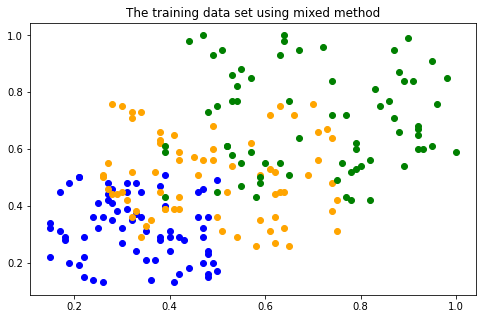

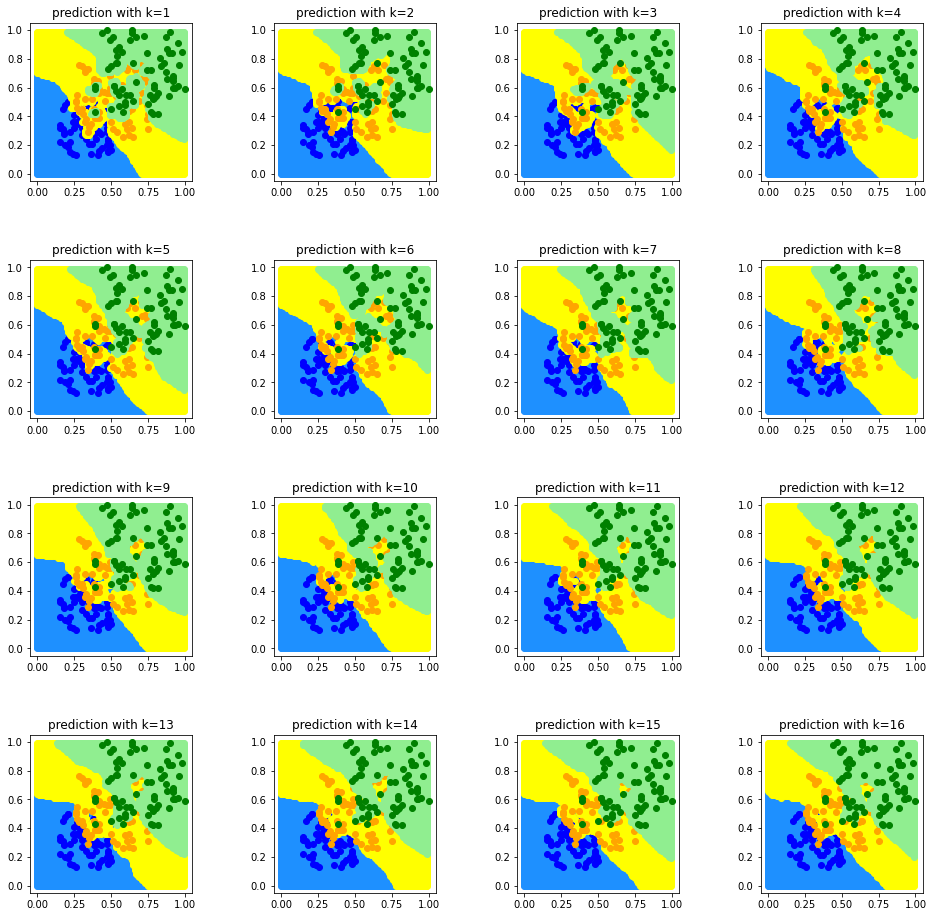

KNN on data set of created using random method, prediction MAP BELLOW


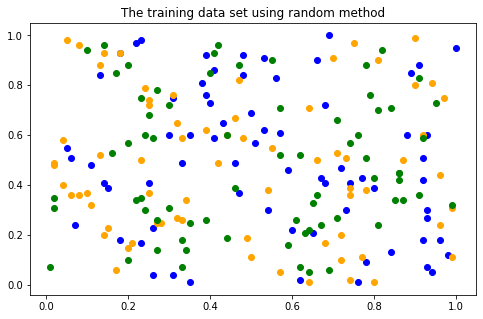

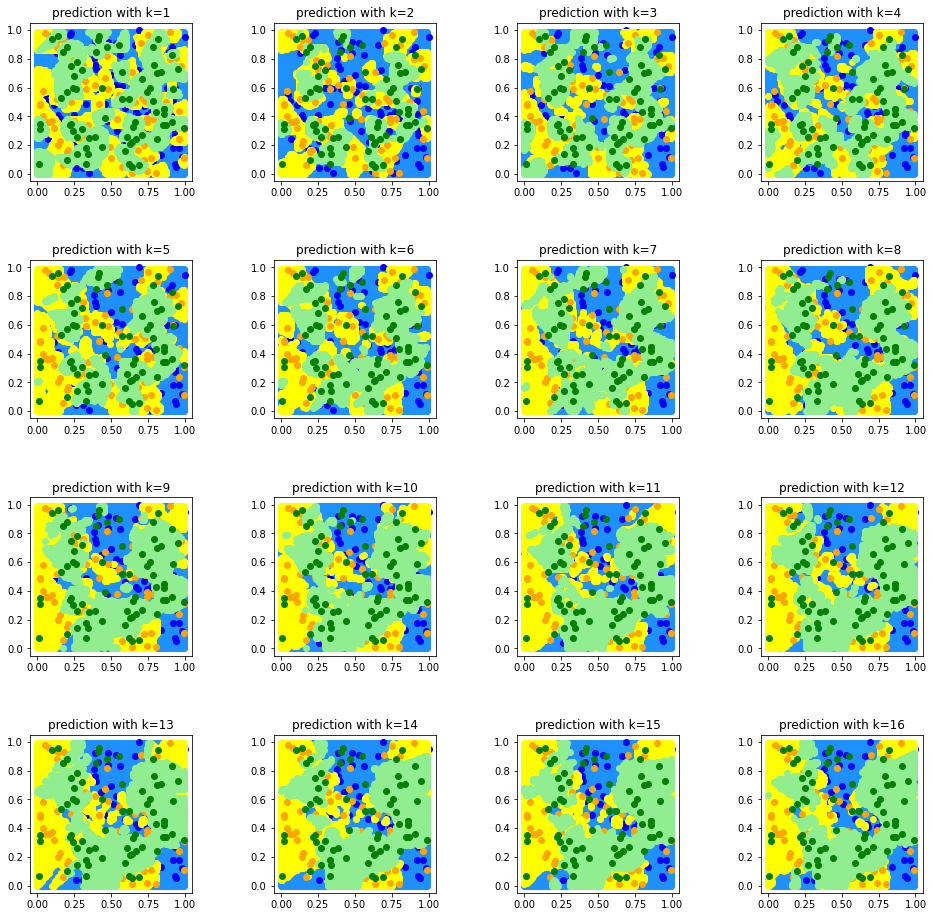

KNN on data set of created using separated method, prediction MAP BELLOW


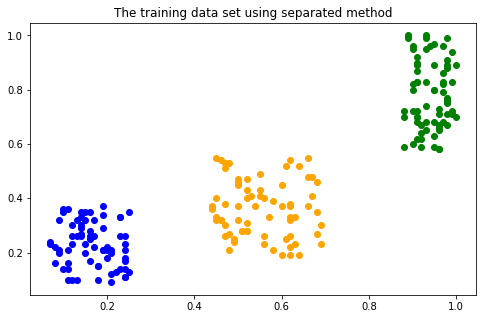

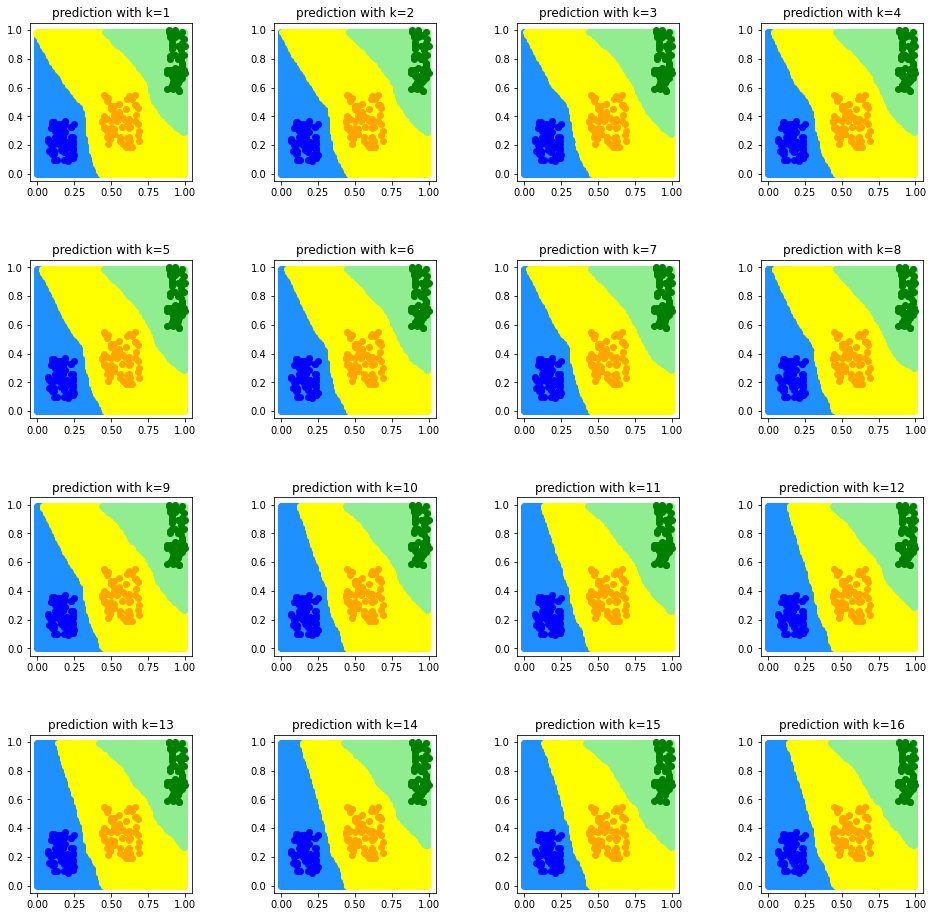

In [128]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5  # width, height

#plotting test and points:
import matplotlib.pyplot as plt
for version in ['mixed','random','separated']:
    X_train, y_train = generate_data(70, version)
    print (f"KNN on data set of created using {version} method, prediction MAP BELLOW")
    for i in range(3):
        a_trn = X_train[np.where(y_train ==i)][:,0]  # grab X_train points for which label is i. grab x coordinate
        b_trn = X_train[np.where(y_train ==i)][:,1]  # grab X_train points for which label is i. grab y coordinate 
        plt.scatter(a_trn, b_trn, color=train_colors[i], label = i,)
    plt.title(f"The training data set using {version} method")
    plt.show()
    
    fig, ax = plt.subplots(4, 4, figsize=(16, 16))
    counter = 0

    for k in range(1,17):
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(X_train,y_train)
        y_pred = knn_model.predict(X_test)

        for i in range(3):
            a_trn = X_train[np.where(y_train ==i)][:,0]  # grab X_train points for which label is i. grab the x coordinate
            b_trn = X_train[np.where(y_train ==i)][:,1]  # grab X_train points for which label is i. grab the y coordinate
            a_tst = X_test[np.where(y_pred ==i)][:,0]    # grab X_train points for which label is i. grab the x coordinate
            b_tst = X_test[np.where(y_pred ==i)][:,1]    # grab X_train points for which label is i. grab the y coordinate

            ax[counter // 4, counter % 4].scatter(a_tst, b_tst, color=test_colors[i])
            ax[counter // 4, counter % 4].scatter(a_trn, b_trn, color=train_colors[i], label = i,)
            ax[counter // 4, counter % 4].set_title(f"prediction with k={k}")

        counter += 1
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()


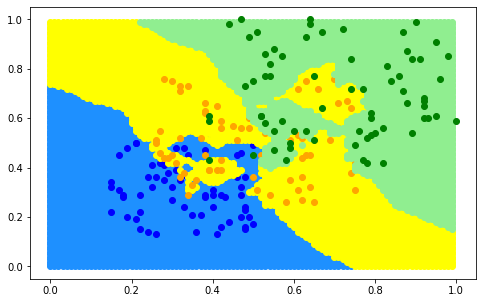

In [110]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5  # width, height

#plotting test and points:
for i in range(3):
    a_trn = X_train[np.where(y_train ==i)][:,0]  # grab X_train points for which label is i. grab the x coordinate
    b_trn = X_train[np.where(y_train ==i)][:,1]  # grab X_train points for which label is i. grab the y coordinate
    a_tst = X_test[np.where(y_pred ==i)][:,0]    # grab X_train points for which label is i. grab the x coordinate
    b_tst = X_test[np.where(y_pred ==i)][:,1]    # grab X_train points for which label is i. grab the y coordinate
    
    plt.scatter(a_tst, b_tst, color=test_colors[i])
    plt.scatter(a_trn, b_trn, color=train_colors[i], label = i,)
    
plt.show()

### Retrospective

Check the results. Do they make sense? Explain the visualization.

Your answer here

# Warm up - Logistic Regression

In [ ]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
        
    return Z

### Create data

In [ ]:
np.random.seed(25)
X, Y = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=0.05
)

colors = ['r' if x else 'g' for x in Y]
plt.scatter(X[:, 0], X[:, 1], marker="o", c=colors, s=25, edgecolor="k")

You are given an already implemented logistic regression class. Understand the code and use it in the next part.

In [ ]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        rgen = np.random.RandomState(self.random_state)
        self.theta = np.random.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        self.cost = []
        old_cost = 0
        output = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (output - y)
            self.theta[1:] -= self.eta * X.T.dot(errors)
            self.theta[0] -= self.eta * errors.sum()
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))).sum() / X.shape[0]
            if abs(cost - old_cost) < self.eps:
                break
            old_cost = cost
            self.cost.append(cost)
    
    def predict(self, X):
        """Return the predicted class label"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
    
    def predict_prob(self, X):
        """Return the predicted class label"""
        return self.activation(self.net_input(X))
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.theta[1:]) + self.theta[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))


## Cross Validation

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

For this part, you can use a straightforward approach and loop on all possible hyper-parameter combinations, or use dedicated functions from `sklearn`.

Shuffle the training set before you split the data to the folds.

In [ ]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

#### Your code here ####

## Model evaluation

1. Build a model with the best params that you found in the previous section.
1. Fit the model to the entire dataset.
1. Print the cross validation score.
1. Use the `plot_decision_regions` function to plot the decision boundaries.
1. Plot the model cost as a function of the iterations.

In [ ]:
#### Your code here ####

## Create 3-classes dataset

In [ ]:
np.random.seed(28)
X, Y = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_classes=3, n_clusters_per_class=1, flip_y=0.05
)
colors = ['r' if x==2 else 'y' if x==1 else 'b' for x in Y]
plt.scatter(X[:, 0], X[:, 1], marker="o", c=colors, s=25, edgecolor="k")
plt.show()

## Create 1-vs-all classifier

1. Notice the `predict_prob` function in the logistic regression class. This functions returns the "probability" to be in the positive class.
1. For each class, create 1-vs-all classifier (a single class would be positive, the rest would be negative) and use the 3 classifiers to predict the class of any instance.
1. Recall that an instance $x$ will be predicted to class $i$ if $P(x$ belongs to class $i) > P(x$ belongs to class $j)\ \forall j \neq i$
1. Print the training accuracy.
1. Store the models in the models variable - you will use it in the evaluation below.

In [ ]:
probs = np.zeros((Y.shape[0], 3))
models = []
#### Your code here ####

Use the models variable and the `plot_decision_regions_3_classes` to plot the decision boundaries.

In [ ]:
# Function for ploting the decision boundaries of a model
def plot_decision_regions_3_classes(X, y, models, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.', '.')
    colors = ('b', 'y', 'r')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = np.zeros((np.array([xx1.ravel(), xx2.ravel()]).T.shape[0], 3))
    Z[:, 0] = models[0].predict_prob(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z[:, 1] = models[1].predict_prob(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z[:, 2] = models[2].predict_prob(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.argmax(axis=1)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
        
    return Z

plot_decision_regions_3_classes(X, Y, models)
plt.show()

# Titanic survival prediction



In this part we will attempt to predict who survived on the Titanic. The data set we use has the following vairbales (features/attributes):


|  Variable   |          Definition          |              Key/Values                 |
|:-----------:|:----------------------------:|:---------------------------------------:|
| PassengerId | Index                        |integer                                  |
| Pclass      | Ticket class                 |1=1st, 2=2nd, 3=3rd                      |
| Name        | Name of passenger            |string                                   |
| Sex         | Sex                          |male, female                             |
| Age         | Age in years                 |integer                                  |
| SibSp       | # of siblings/spouses aboard |integer                                  |
| Parch       | # of parents/children aboard |integer                                  |
| Ticket      | Ticket number                |string                                   |
| Fare        | Ticket fare                  |float                                    |
| Cabin       | Cabin number                 |a code                                   |
| Embarked    | Port of Embarkation          |C=Cherbourg, Q=Queenstown, S=Southampton |
| **Survived**| Predicted varibale           |0=No, 1=Yes                              |


**Goal:**

The goal is to produce the best score possible.

**Methodogology**

So far you only two methods for classification: KNN and logistic regression. You can also use linear regression, but then you need to convert the output to 0s and 1s (this is not a straight forward use of linear regression but a possible one). You may want to choose which features to use (it could be that some features are not useful). Further, some features have missing values. You will need to decide how to handle this (for instance: drop rows with missing values, place an avergae value in those rows, or some other method of your choosing). Another matter to consider is handling non-numeric values. For example, sex is non-numeric. You may choose to drop non-numeric features, or you could convert them to numeric values (if such conversion makes sense).
Also you will need to consider splitting the data into a training set and a test set so as to avoid tailoring the solution (overfitting) to the data you have.

Bottom line: use everything we talked about in class in order to learn the best model.


**Model Output**

Your model needs to produce a prediciton for each data sample (row), which is 0 (did not survive) or 1 (survived). 

**Scoring your model**

Your model performance will be assessed on test data that is not available to you (you will see the score next semester). Try to avoid overfitting.

<br><br>
**Final Note**

This part of the project is open ended, in that you are not given small and specific tasks. However, you are already familiar with all the components needed to succeed. Specifically, reading data into pandas dataframe, dropping columns, dropping rows, changing value of features, splitting data into train and test subsets and performing model training and hyper parameter tuning via cross validation using sklearn library.

GOOD LUCK